In [14]:
import os
import xarray as xr
import numpy as np
import xesmf as xe

In [15]:
path = r"C:\Users\Felicio.Cassalho\Work/Modeling/AK_Project/WaveCu_paper/OWI_wind/"
owi_all = xr.concat([xr.open_dataset(path+f"OWI_Alaska_Basin/2019{i:02d}_Region.win.nc", format ='netcdf4') for i in range (6,12)], dim='time')
air_files = os.listdir(path+r"sflux/")
output_dir = r'sflux_era5_owi/'

In [16]:
_, unique_indices = np.unique(owi_all['time'], return_index=True)
owi_all = owi_all.isel(time=unique_indices)

In [17]:
owi = owi_all.rename({
    'latitude': 'ny_grid',
    'longitude': 'nx_grid',
    'u10': 'uwind',
    'v10': 'vwind'
})
lon_2d, lat_2d = np.meshgrid(owi['nx_grid'].values, owi['ny_grid'].values)
owi = owi.assign_coords(
    lon=(('ny_grid', 'nx_grid'), lon_2d.astype(np.float32)),
    lat=(('ny_grid', 'nx_grid'), lat_2d.astype(np.float32))
)

In [19]:
for i,air_file in enumerate(air_files):
    air = xr.open_dataset(path+f"sflux/{air_file}")
    
    owi_time_aligned = owi.interp(time=air.time, method="linear")
    regridder = xe.Regridder(
        owi_time_aligned,
        air,
        "bilinear",
        unmapped_to_nan=True,
        periodic=False
    )

    owi_regridded = regridder(owi_time_aligned[['uwind', 'vwind']])
    merged_ds = air.copy(deep=True)

    merged_ds['uwind'] = xr.where(
        owi_regridded['uwind'].notnull(),
        owi_regridded['uwind'],
        air['uwind']
    )
    
    merged_ds['vwind'] = xr.where(
        owi_regridded['vwind'].notnull(),
        owi_regridded['vwind'],
        air['vwind']
    )

    merged_ds.attrs['history'] = f"Original sflux data merged with high-resolution OWI wind fields on {np.datetime64('now', 's')}."
    merged_ds.attrs['source'] = "sflux_air (base) and OWI (inlay)"
    merged_ds.attrs['comment'] = "High-resolution OWI wind data was bilinearly interpolated and used where available."

    merged_ds.to_netcdf(f"{path}{output_dir}/{air_file}")
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136


In [20]:
owi_era = xr.open_dataset(f"{path}{output_dir}/sflux_air_1.0001.nc", format ='netcdf4') 

In [21]:
era = xr.open_dataset(f"{path}sflux/sflux_air_1.0001.nc", format ='netcdf4') 

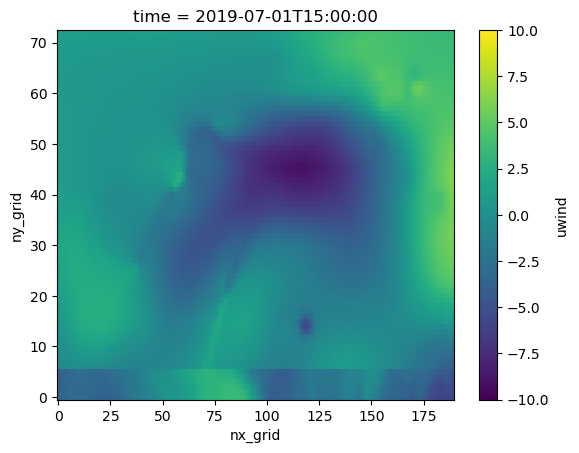

In [63]:
owi_era['uwind'][15].plot(vmin=-10,vmax=10)

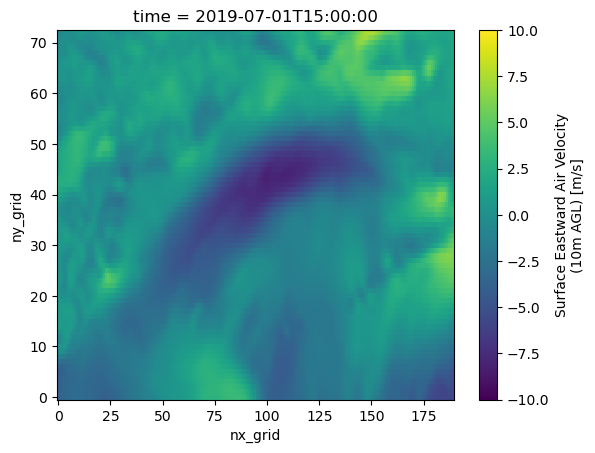

In [57]:
era['uwind'][15].plot(vmin=-10,vmax=10)

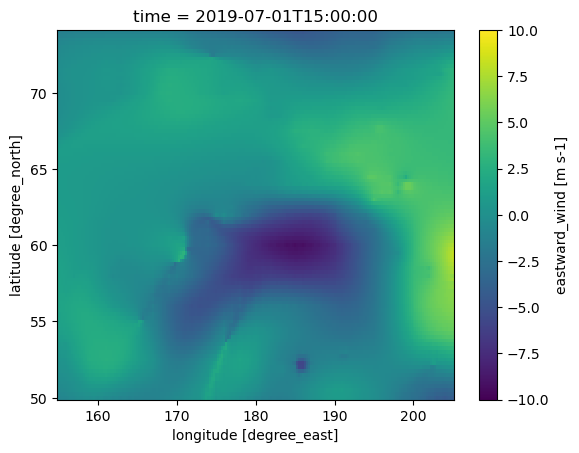

In [61]:
owi_all['u10'][240+5].plot(vmin=-10,vmax=10)

In [40]:
owi_all['u10']

<xarray.DataArray 'u10' (time: 1465, latitude: 97, longitude: 201)> Size: 114MB
array([[[-1.3144, -1.3701, -1.4251, ...,  3.7101,  3.762 ,  3.8136],
        [-1.4666, -1.5018, -1.5368, ...,  3.6852,  3.7403,  3.795 ],
        [-1.5347, -1.5982, -1.6603, ...,  3.6489,  3.7255,  3.8017],
        ...,
        [-5.0642, -5.0821, -5.0989, ..., -7.2587, -7.2488, -7.2389],
        [-4.9493, -4.9667, -4.983 , ..., -6.9999, -6.9873, -6.9747],
        [-4.8175, -4.8403, -4.8619, ..., -6.7822, -6.78  , -6.7777]],

       [[-1.9965, -1.9547, -1.9021, ...,  2.7761,  2.8187,  2.861 ],
        [-2.1818, -2.1102, -2.0197, ...,  2.8081,  2.8777,  2.9467],
        [-2.304 , -2.2281, -2.1351, ...,  2.8331,  2.9363,  3.0388],
        ...,
        [-4.4482, -4.4642, -4.4795, ..., -7.3342, -7.3304, -7.3266],
        [-4.3219, -4.3388, -4.3552, ..., -7.0777, -7.0688, -7.0598],
        [-4.1792, -4.2028, -4.2256, ..., -6.867 , -6.8697, -6.8723]],

       [[-2.2457, -2.1578, -2.0266, ...,  1.7094,  1.7249,  1.74  ],
        [-2.4395, -2.3186, -2.1382, ...,  1.7693,  1.8216,  1.8735],
        [-2.5798, -2.4404, -2.2393, ...,  1.8274,  1.9122,  1.9966],
        ...,
...
        [ 2.1895,  2.18  ,  2.1684, ..., -0.5116, -0.4348, -0.2898],
        [ 2.4055,  2.3656,  2.3223, ..., -0.3169, -0.2802, -0.2282],
        [ 2.5009,  2.4514,  2.3983, ..., -0.1125, -0.081 , -0.0328]],

       [[12.3385, 12.3578, 12.377 , ...,  9.3014,  9.4062,  9.5035],
        [12.2515, 12.2763, 12.3009, ...,  8.9642,  8.9798,  8.9927],
        [12.1335, 12.1546, 12.1752, ...,  8.5254,  8.5597,  8.5921],
        ...,
        [ 2.4704,  2.4693,  2.466 , ..., -0.7514, -0.654 , -0.4968],
        [ 2.7562,  2.7269,  2.6944, ..., -0.4632, -0.4209, -0.3607],
        [ 2.9456,  2.9084,  2.8677, ..., -0.1963, -0.1582, -0.1067]],

       [[12.482 , 12.5229, 12.5633, ...,  9.5874,  9.7444,  9.886 ],
        [12.408 , 12.4533, 12.4979, ...,  9.2669,  9.3479,  9.4178],
        [12.3096, 12.349 , 12.3875, ...,  8.8271,  8.9268,  9.0174],
        ...,
        [ 2.5257,  2.5204,  2.5123, ..., -0.9963, -0.8837, -0.7131],
        [ 2.8896,  2.8598,  2.8269, ..., -0.6139, -0.5724, -0.5099],
        [ 3.167 ,  3.133 ,  3.0957, ..., -0.2807, -0.2471, -0.1981]]],
      shape=(1465, 97, 201), dtype=float32)
Coordinates:
  * longitude  (longitude) float32 804B 155.0 155.2 155.5 ... 204.5 204.8 205.0
  * latitude   (latitude) float32 388B 50.0 50.25 50.5 50.75 ... 73.5 73.75 74.0
  * time       (time) datetime64[ns] 12kB 2019-06-01 ... 2019-12-01
Attributes:
    units:      m s-1
    field:      U, scalar, series
    long_name:  eastward_wind

In [33]:
era.time[0]

<xarray.DataArray 'time' ()> Size: 8B
array('2019-07-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2019-07-01
Attributes:
    long_name:      Time
    standard_name:  time
    base_date:      [2019    7    1    0]

In [30]:
owi_all.time[240]

<xarray.DataArray 'time' ()> Size: 8B
array('2019-07-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2019-07-01
Attributes:
    long_name:  julian day (UT)
    field:      time, scalar, series
    base_date:  1990-01-01 00:00:00 UTC
    axis:       T

In [ ]:
path+r"sflux/"

In [ ]:
f"{path}{output_dir}/sflux_air_1.0001.nc"

In [ ]:
air = xr.open_dataset(path+r"sflux/sflux_air_1.0001.nc")

In [61]:
owi = owi.rename({
    'latitude': 'ny_grid',
    'longitude': 'nx_grid',
    'u10': 'uwind',
    'v10': 'vwind'
})

In [62]:
lon_2d, lat_2d = np.meshgrid(owi['nx_grid'].values, owi['ny_grid'].values)

In [63]:
owi = owi.assign_coords(
    lon=(('ny_grid', 'nx_grid'), lon_2d.astype(np.float32)),
    lat=(('ny_grid', 'nx_grid'), lat_2d.astype(np.float32))
)

In [64]:
owi_time_aligned = owi.interp(time=air.time, method="linear")

In [65]:
regridder = xe.Regridder(
    owi_time_aligned,
    air,
    "bilinear",
    unmapped_to_nan=True,
    periodic=False # Set to True if longitude is periodic
)

In [66]:
owi_regridded = regridder(owi_time_aligned[['uwind', 'vwind']])

In [67]:
merged_ds = air.copy(deep=True)

In [68]:
merged_ds['uwind'] = xr.where(
    owi_regridded['uwind'].notnull(),
    owi_regridded['uwind'],
    air['uwind']
)

merged_ds['vwind'] = xr.where(
    owi_regridded['vwind'].notnull(),
    owi_regridded['vwind'],
    air['vwind']
)

In [81]:
merged_ds.attrs['history'] = f"Original sflux data merged with high-resolution OWI wind fields on {np.datetime64('now', 's')}."
merged_ds.attrs['source'] = "sflux_air (base) and OWI (inlay)"
merged_ds.attrs['comment'] = "High-resolution OWI wind data was bilinearly interpolated and used where available."

In [83]:
air

<xarray.Dataset> Size: 7MB
Dimensions:  (ny_grid: 73, nx_grid: 190, time: 25)
Coordinates:
  * time     (time) datetime64[ns] 200B 2019-07-01 ... 2019-07-02
Dimensions without coordinates: ny_grid, nx_grid
Data variables:
    lon      (ny_grid, nx_grid) float32 55kB 156.2 156.4 156.7 ... 203.2 203.4
    lat      (ny_grid, nx_grid) float32 55kB 48.61 48.61 48.61 ... 66.61 66.61
    prmsl    (time, ny_grid, nx_grid) float32 1MB ...
    spfh     (time, ny_grid, nx_grid) float32 1MB ...
    stmp     (time, ny_grid, nx_grid) float32 1MB ...
    uwind    (time, ny_grid, nx_grid) float32 1MB -4.758 -4.507 ... 1.578 1.752
    vwind    (time, ny_grid, nx_grid) float32 1MB -4.075 -4.003 ... 1.35 1.115
Attributes:
    Conventions:  CF-1.0

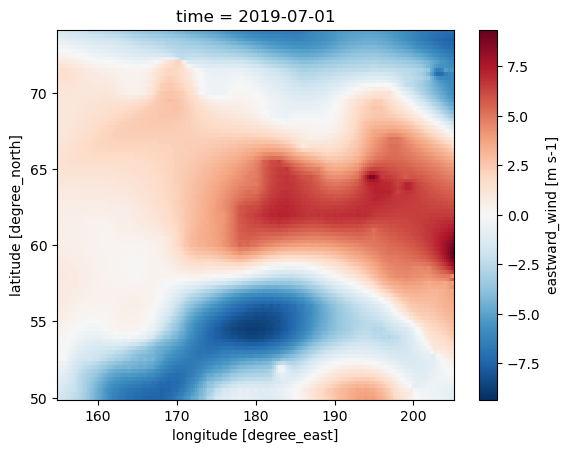

In [78]:
owi.uwind[0].plot()

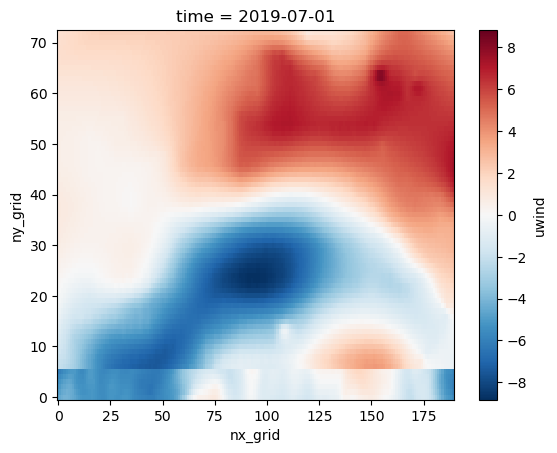

In [79]:
merged_ds['uwind'][0].plot()

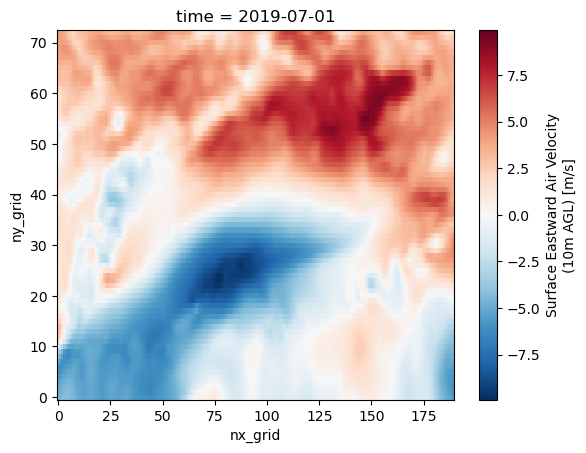

In [80]:
air['uwind'][0].plot()

In [53]:
# 1. Create the new 2D coordinate variables from the original 1D coordinates
lon_coords_1d = owi['longitude'].values
lat_coords_1d = owi['latitude'].values
lon_2d, lat_2d = np.meshgrid(lon_coords_1d, lat_coords_1d)

In [54]:
owi = owi.rename({
                  'latitude': 'ny_grid',
                  'longitude': 'nx_grid',
                  'u10': 'uwind',
                  'v10': 'vwind'
                 })

owi = owi.reset_index(['ny_grid', 'nx_grid'], drop=True)

owi = owi.assign(
                 lon=(('ny_grid', 'nx_grid'), lon_2d.astype(np.float32)),
                 lat=(('ny_grid', 'nx_grid'), lat_2d.astype(np.float32))
                 )   

In [55]:
owi_time_aligned = owi.interp(time=air.time, method="linear")

In [58]:
air

<xarray.Dataset> Size: 7MB
Dimensions:  (ny_grid: 73, nx_grid: 190, time: 25)
Coordinates:
  * time     (time) datetime64[ns] 200B 2019-07-01 ... 2019-07-02
Dimensions without coordinates: ny_grid, nx_grid
Data variables:
    lon      (ny_grid, nx_grid) float32 55kB 156.2 156.4 156.7 ... 203.2 203.4
    lat      (ny_grid, nx_grid) float32 55kB 48.61 48.61 48.61 ... 66.61 66.61
    prmsl    (time, ny_grid, nx_grid) float32 1MB ...
    spfh     (time, ny_grid, nx_grid) float32 1MB ...
    stmp     (time, ny_grid, nx_grid) float32 1MB ...
    uwind    (time, ny_grid, nx_grid) float32 1MB ...
    vwind    (time, ny_grid, nx_grid) float32 1MB ...
Attributes:
    Conventions:  CF-1.0

In [56]:
regridder = xe.Regridder(owi_time_aligned,
                         air,
                         method='bilinear',
                         periodic=False,
                         # reuse_weights=True
                        )
owi_regridded = regridder(owi_time_aligned)

In [44]:
owi_coverage_mask = ~np.isnan(owi_regridded['uwind'].isel(time=0))

In [48]:
owi['lon'].values

array([[155.  , 155.25, 155.5 , ..., 204.5 , 204.75, 205.  ],
       [155.  , 155.25, 155.5 , ..., 204.5 , 204.75, 205.  ],
       [155.  , 155.25, 155.5 , ..., 204.5 , 204.75, 205.  ],
       ...,
       [155.  , 155.25, 155.5 , ..., 204.5 , 204.75, 205.  ],
       [155.  , 155.25, 155.5 , ..., 204.5 , 204.75, 205.  ],
       [155.  , 155.25, 155.5 , ..., 204.5 , 204.75, 205.  ]],
      shape=(97, 201), dtype=float32)

In [49]:
owi['lat'].values

array([[50.  , 50.  , 50.  , ..., 50.  , 50.  , 50.  ],
       [50.25, 50.25, 50.25, ..., 50.25, 50.25, 50.25],
       [50.5 , 50.5 , 50.5 , ..., 50.5 , 50.5 , 50.5 ],
       ...,
       [73.5 , 73.5 , 73.5 , ..., 73.5 , 73.5 , 73.5 ],
       [73.75, 73.75, 73.75, ..., 73.75, 73.75, 73.75],
       [74.  , 74.  , 74.  , ..., 74.  , 74.  , 74.  ]],
      shape=(97, 201), dtype=float32)

In [50]:
owi_coverage_mask

<xarray.DataArray 'uwind' (ny_grid: 73, nx_grid: 190)> Size: 14kB
array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]], shape=(73, 190))
Coordinates:
    time     datetime64[ns] 8B 2019-07-01
Dimensions without coordinates: ny_grid, nx_grid

In [47]:
owi_mask_ds = xr.Dataset({
    "mask": owi_coverage_mask.astype(float),
    "lon": (('ny_grid', 'nx_grid'), owi['lon'].values),
    "lat": (('ny_grid', 'nx_grid'), owi['lat'].values),
})

ValueError: conflicting sizes for dimension 'ny_grid': length 97 on 'lon' and length 73 on {'ny_grid': 'mask', 'nx_grid': 'mask'}

In [35]:
valid_mask = ~np.isnan(owi_regridded['uwind'])

In [37]:
uwind_combined = xr.where(valid_mask, owi_regridded['uwind'], air['uwind'])
vwind_combined = xr.where(valid_mask, owi_regridded['vwind'], air['vwind'])

In [38]:
combined = air.copy()
combined['uwind'] = uwind_combined
combined['vwind'] = vwind_combined

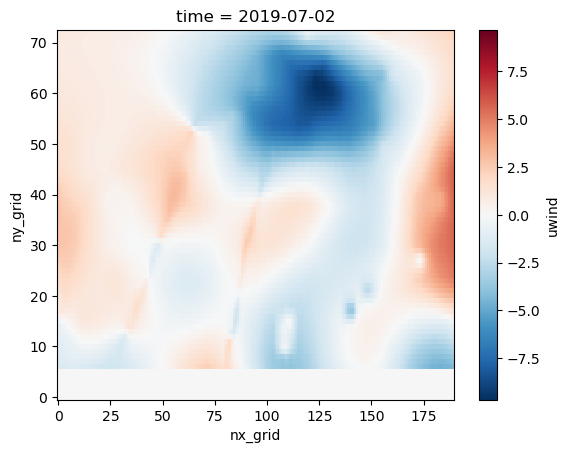

In [41]:
combined.uwind[-1].plot()

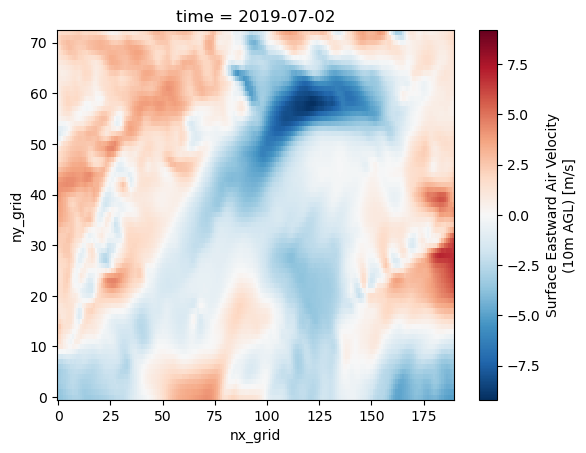

In [42]:
air.uwind[-1].plot()

In [5]:
# 1. Create the new 2D coordinate variables from the original 1D coordinates
lon_coords_1d = owi['longitude'].values
lat_coords_1d = owi['latitude'].values
lon_2d, lat_2d = np.meshgrid(lon_coords_1d, lat_coords_1d)

# 2. Rename the dimensions and data variables
owi_reformatted = owi.rename({
    'latitude': 'ny_grid',
    'longitude': 'nx_grid',
    'u10': 'uwind',
    'v10': 'vwind'
})

In [6]:
# 3. CORRECTED STEP: Use reset_index() with drop=True
# This removes the index AND the associated 1D coordinate variables.
owi_reformatted = owi_reformatted.reset_index(['ny_grid', 'nx_grid'], drop=True)

In [7]:
# 4. Assign the new 2D 'lon' and 'lat' as data variables
owi_reformatted = owi_reformatted.assign(
    lon=(('ny_grid', 'nx_grid'), lon_2d.astype(np.float32)),
    lat=(('ny_grid', 'nx_grid'), lat_2d.astype(np.float32))
)

In [8]:
owi_time_aligned = owi_reformatted.interp(time=air.time, method="linear")

In [13]:
regridder = xe.Regridder(owi_time_aligned,
                         air,
                         method='bilinear',
                         periodic=False,
                         # reuse_weights=True
                        )

In [15]:
regridded_list=[]
for t in range(len(owi_time_aligned.time)):
    single_timestep = owi_time_aligned.isel(time=t)
    regrid_step = regridder(single_timestep)
    regridded_list.append(regrid_step)

In [16]:
owi_regridded = xr.concat(regridded_list, dim='time')
owi_regridded['time'] = owi_time_aligned['time']

In [17]:
owi_regridded

<xarray.Dataset> Size: 8MB
Dimensions:  (time: 25, ny_grid: 73, nx_grid: 190)
Coordinates:
  * time     (time) datetime64[ns] 200B 2019-07-01 ... 2019-07-02
Dimensions without coordinates: ny_grid, nx_grid
Data variables:
    uwind    (time, ny_grid, nx_grid) float64 3MB 0.0 0.0 0.0 ... 2.089 2.153
    vwind    (time, ny_grid, nx_grid) float64 3MB 0.0 0.0 0.0 ... 5.156 5.086
    lon      (time, ny_grid, nx_grid) float32 1MB 0.0 0.0 0.0 ... 203.2 203.4
    lat      (time, ny_grid, nx_grid) float32 1MB 0.0 0.0 0.0 ... 66.61 66.61
Attributes:
    regrid_method:  bilinear

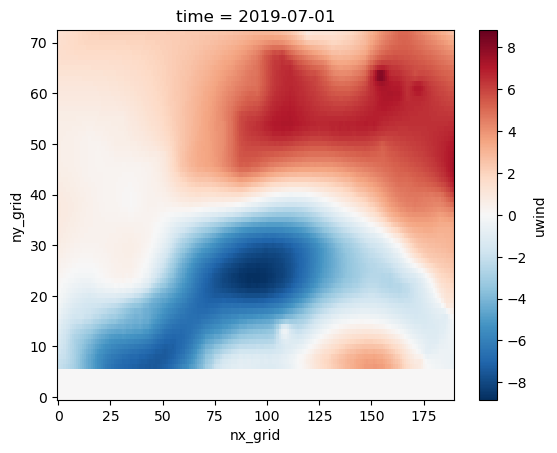

In [24]:
owi_regridded.uwind[0].plot()

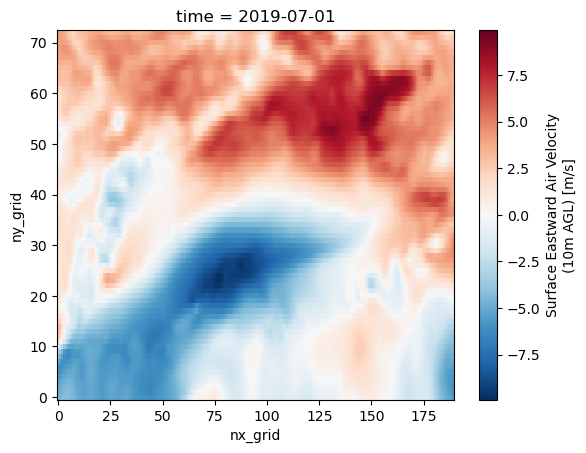

In [23]:
air.uwind[0].plot()

In [12]:
owi_final = regridder(owi_time_aligned)

In [21]:
owi_final.uwind.plot()

ImportError: The matplotlib package is required for plotting but could not be imported. Please install it with your package manager (e.g. conda or pip).

In [17]:
help(xe.Regridder)

Help on class Regridder in module xesmf.frontend:

class Regridder(BaseRegridder)
 |  Regridder(
 |      ds_in,
 |      ds_out,
 |      method,
 |      locstream_in=False,
 |      locstream_out=False,
 |      periodic=False,
 |      parallel=False,
 |      **kwargs
 |  )
 |
 |  Method resolution order:
 |      Regridder
 |      BaseRegridder
 |      builtins.object
 |
 |  Methods defined here:
 |
 |  __init__(
 |      self,
 |      ds_in,
 |      ds_out,
 |      method,
 |      locstream_in=False,
 |      locstream_out=False,
 |      periodic=False,
 |      parallel=False,
 |      **kwargs
 |  )
 |      Make xESMF regridder
 |
 |      Parameters
 |      ----------
 |      ds_in, ds_out : xarray Dataset, DataArray, or dictionary
 |          Contain input and output grid coordinates.
 |          All variables that the cf-xarray accessor understand are accepted.
 |          Otherwise, look for ``lon``, ``lat``,
 |          optionally ``lon_b``, ``lat_b`` for conservative methods,
 |      

In [16]:
owi_final.uwind.values

array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [1.4528771 , 1.49554826, 1.53819419, ..., 3.58448466,
         3.48286379, 3.37919262],
        [1.40367925, 1.44917422, 1.49566507, ..., 3.2454674 ,
         3.13083847, 3.01382823],
        [1.34931331, 1.39514834, 1.44270264, ..., 2.87058942,
         2.74086464, 2.60831062]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [1.421173  , 1.46078839, 1.49977475, ..., 3.53694698,
         3.43431826, 3.329586  ],
        [1.3

In [15]:
air.uwind.values

array([[[-4.758363  , -4.507386  , -4.3325815 , ..., -5.1533823 ,
         -5.2769175 , -5.6035776 ],
        [-5.019105  , -4.7700815 , -4.545472  , ..., -5.352601  ,
         -5.5757456 , -5.921937  ],
        [-5.2315073 , -4.9712534 , -4.752015  , ..., -5.5371714 ,
         -5.757386  , -6.0093393 ],
        ...,
        [ 3.946227  ,  4.0682974 ,  4.173278  , ...,  2.82611   ,
          2.7103872 ,  2.7484732 ],
        [ 4.0585318 ,  4.1434927 ,  4.07318   , ...,  2.2440786 ,
          2.3563833 ,  2.4481802 ],
        [ 4.0785513 ,  4.1727896 ,  4.1015005 , ...,  1.6654654 ,
          1.8099966 ,  2.0199575 ]],

       [[-5.0704985 , -4.8551664 , -4.6798735 , ..., -5.9523344 ,
         -6.066592  , -6.123721  ],
        [-5.2492094 , -5.036807  , -4.8273344 , ..., -6.019229  ,
         -6.1120024 , -6.2194242 ],
        [-5.324893  , -5.114932  , -4.9298735 , ..., -6.005557  ,
         -6.1539946 , -6.349307  ],
        ...,
        [ 3.81915   ,  4.0315523 ,  4.187314  , ...,  

In [8]:
owi_reformatted

<xarray.Dataset> Size: 39MB
Dimensions:  (time: 249, ny_grid: 97, nx_grid: 201)
Coordinates:
  * time     (time) datetime64[ns] 2kB 2019-07-01 ... 2019-08-01
Dimensions without coordinates: ny_grid, nx_grid
Data variables:
    uwind    (time, ny_grid, nx_grid) float32 19MB ...
    vwind    (time, ny_grid, nx_grid) float32 19MB ...
    lon      (ny_grid, nx_grid) float32 78kB 155.0 155.2 155.5 ... 204.8 205.0
    lat      (ny_grid, nx_grid) float32 78kB 50.0 50.0 50.0 ... 74.0 74.0 74.0
Attributes:
    start_date:  01-Jul-2019
    stop_date:   01-Aug-2019
    source:      OWI
    field type:  3 hr
    content:     10-meter wind components

In [9]:
air

<xarray.Dataset> Size: 7MB
Dimensions:  (ny_grid: 73, nx_grid: 190, time: 25)
Coordinates:
  * time     (time) datetime64[ns] 200B 2019-07-01 ... 2019-07-02
Dimensions without coordinates: ny_grid, nx_grid
Data variables:
    lon      (ny_grid, nx_grid) float32 55kB ...
    lat      (ny_grid, nx_grid) float32 55kB ...
    prmsl    (time, ny_grid, nx_grid) float32 1MB ...
    spfh     (time, ny_grid, nx_grid) float32 1MB ...
    stmp     (time, ny_grid, nx_grid) float32 1MB ...
    uwind    (time, ny_grid, nx_grid) float32 1MB ...
    vwind    (time, ny_grid, nx_grid) float32 1MB ...
Attributes:
    Conventions:  CF-1.0

In [86]:
owi_reformatted.lon.values

array([[155.  , 155.25, 155.5 , ..., 204.5 , 204.75, 205.  ],
       [155.  , 155.25, 155.5 , ..., 204.5 , 204.75, 205.  ],
       [155.  , 155.25, 155.5 , ..., 204.5 , 204.75, 205.  ],
       ...,
       [155.  , 155.25, 155.5 , ..., 204.5 , 204.75, 205.  ],
       [155.  , 155.25, 155.5 , ..., 204.5 , 204.75, 205.  ],
       [155.  , 155.25, 155.5 , ..., 204.5 , 204.75, 205.  ]],
      dtype=float32)

In [85]:
owi_reformatted.lat.values

array([[50.  , 50.  , 50.  , ..., 50.  , 50.  , 50.  ],
       [50.25, 50.25, 50.25, ..., 50.25, 50.25, 50.25],
       [50.5 , 50.5 , 50.5 , ..., 50.5 , 50.5 , 50.5 ],
       ...,
       [73.5 , 73.5 , 73.5 , ..., 73.5 , 73.5 , 73.5 ],
       [73.75, 73.75, 73.75, ..., 73.75, 73.75, 73.75],
       [74.  , 74.  , 74.  , ..., 74.  , 74.  , 74.  ]], dtype=float32)

In [84]:
air.lat.values

array([[48.609, 48.609, 48.609, ..., 48.609, 48.609, 48.609],
       [48.859, 48.859, 48.859, ..., 48.859, 48.859, 48.859],
       [49.109, 49.109, 49.109, ..., 49.109, 49.109, 49.109],
       ...,
       [66.109, 66.109, 66.109, ..., 66.109, 66.109, 66.109],
       [66.359, 66.359, 66.359, ..., 66.359, 66.359, 66.359],
       [66.609, 66.609, 66.609, ..., 66.609, 66.609, 66.609]],
      dtype=float32)